### This notebook will show analysis of yellow taxis in New York in 2016.
We access dataset by bigquery cell magic, completing several queries and uploading them into pandas dataframe for easier manipulation.

In [1]:
#Load necessary libraries

%load_ext google.cloud.bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rcParams
import seaborn as sns
%matplotlib inline

The first question we want to answer is:<br>
**How does number of trips, average trips time, average trips cost and average trips distance changes over time of the day?<br>
Can we see high and low demand during a day?**

In [2]:
%%bigquery df_trip
SELECT  Extract(hour from pickup_datetime) as trip_hour, 
        COUNT(*) as trip_count,

        ROUND(AVG(TIMESTAMP_DIFF(dropoff_datetime, pickup_datetime, minute)),2) as trip_avg_time_m,
        ROUND(AVG(trip_distance),2) as trip_avg_distance_mile,
        ROUND(AVG(total_amount),2) as trip_avg_total_amount,

        Round(AVG(total_amount) / AVG(TIMESTAMP_DIFF(dropoff_datetime, pickup_datetime, minute)),2) as trip_price_per_minute,
        Round(AVG(total_amount) / avg(trip_distance),2) as trip_price_per_mile        
FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
GROUP BY trip_hour
ORDER BY trip_hour

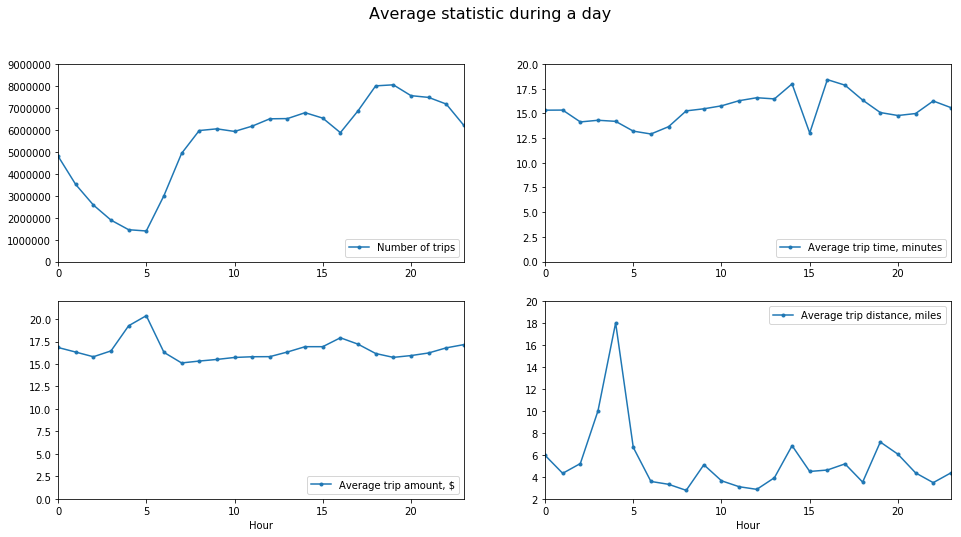

In [3]:
#Plot Average statistic during a day: Number of trips, Average trip time, Average trip cost, Average trip distance

plt.figure(figsize=(16,8))
plt.suptitle('Average statistic during a day', fontsize = 16)

plt.subplot(221)
plt.plot(df_trip['trip_hour'], df_trip['trip_count'], '.-', label='Number of trips')
plt.axis([0,23,0,9000000])
leg = plt.legend(loc = 'lower right')

plt.subplot(222)
plt.plot(df_trip['trip_hour'], df_trip['trip_avg_time_m'], '.-', label='Average trip time, minutes')
plt.axis([0,23,0,20])
leg = plt.legend(loc = 'lower right')

plt.subplot(223)
plt.plot(df_trip['trip_hour'], df_trip['trip_avg_total_amount'], '.-', label='Average trip amount, $')
plt.xlabel('Hour')
plt.axis([0,23,0,22])
leg = plt.legend(loc = 'lower right')

plt.subplot(224)
plt.plot(df_trip['trip_hour'], df_trip['trip_avg_distance_mile'], '.-', label='Average trip distance, miles')
plt.xlabel('Hour')
plt.axis([0,23,2,20])
leg = plt.legend(loc = 'upper right')

plt.subplots_adjust(hspace=0.2)
plt.show()

After plotting number of trips and average statistic over day hour, our observations are as following.

Number of trips has pick around 18 - 19 hours, with period 17 - 23 hours being the busiest over the day with 8M+ trips. Nighttime demand gradually drops almost 5 times from 5M trips at 0 hours to 1M+ trips at 5 hours, while lesser people stay awake. As more people wake up and travel to work, morning demand climbs ~6 times over period of 5 to 8 hours to around 6M trips. Interesting, that number of trips has drop at 16 hours, will try to investigate it later.

Average trip time varies from 13 minutes to 18.5 minutes with picks at 14, 16 and 17 hours. Lowest trip time happens at 6 and 15 hours. Overall, variation of trip time is not too big, but dip at 15 hours is obvious and need further investigation.

Average trip amount varies from ~USD15 to ~USD21 with peak at 5 hours (~USD21) and lesser peaks at 16 hours (~USD18) and 23 hours (~USD17.5). Low average trip amount happens at 2 hours (~USD16), 7 hours (~USD15) and 19 hours (~USD15.5). Pattern of average trip amount chart looks as mirror image to number of trips chart pattern. We will check correlation later.

Average trip distance varies from ~2.5 miles to ~18 miles with peak at 4 hours (~18 miles) and local peaks at 0 hours (~6 miles), 9 hours (~5 miles), 14 hours (~7 miles), 19 hours (~7.5 miles). Shortest trips are at 8 hours (~2.5 miles), 12 hours (~2.5 miles), 18 hours (~3 miles), 22 hours (~3 miles). There is an interesting pattern of 5 points drop starting from 4 hours in the morning: trip distance is highest at first point and decreases over next 4 points. It repeats throughout a day but not applicable during nighttime.

**Summary.**<br>
*People of New York use yellow taxis mostly from 8 to 23 hours, with period 17 to 23 hours being the busiest over the day. Lowest taxi usage is during nighttime from 1 to 6 hours.<br>
Average trip time varies from 13 to 18.5 minutes throughout a day with unusual dip at 15 hours (~12.5 minute).<br>
Average trip amount varies from ~USD15 to ~USD21 and possibly has negative correlation with number of trips.<br>
Average trip distance varies from ~2.5 miles to ~18 miles with most of the trips happens within 2.5 - 7.5 miles (for comparison, Manhattan Island is 13.4 miles long and 2.3 miles wide). There is unusual peak at 4 hours (~18 miles).<br>*

To investigate further, we can split statistic by weekday and check if weekdays and weekends follow the same pattern.

To check possible correlations between our variables, let's look at pairwise relationship charts.

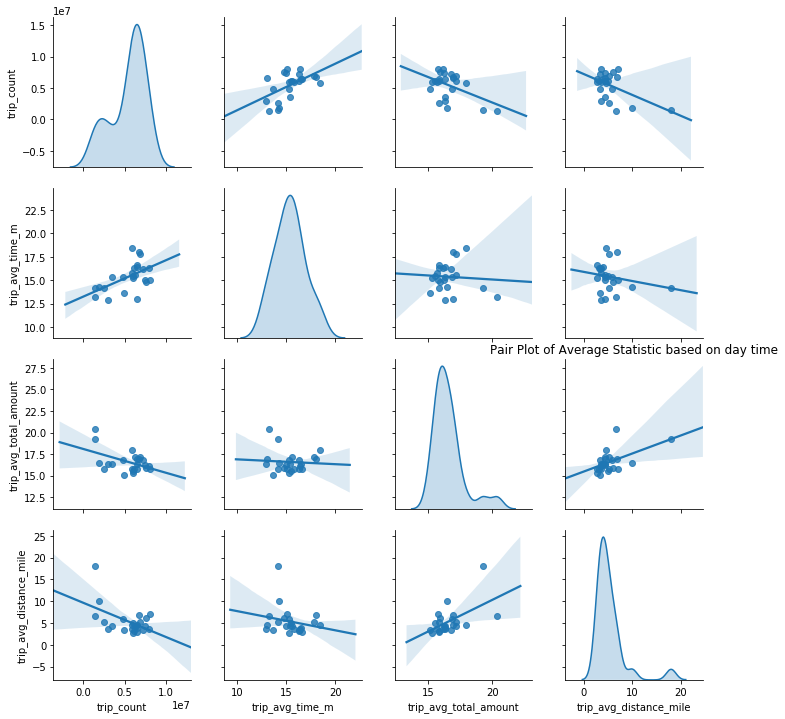

In [4]:
#Plot pairwise relationships in a dataset with regression: 
#Trip hour, Number of trips, Average trip time, Average trip distance, Average trip cost, Average price per minute, Average price per mile

sns.pairplot(df_trip, vars = ('trip_count','trip_avg_time_m','trip_avg_total_amount','trip_avg_distance_mile'),kind='reg',diag_kind="kde")
plt.title('Pair Plot of Average Statistic based on day time')
plt.show()

*This shows, that average trip amount does have negative moderate correlation with number of trips with data points gathered around one area.*

Before we proceed to weekday statistic, let's answer another question:<br>
**How does average trip price per minute and per mile changes over time of the day? <br>
When is it more profitable for taxi drivers to have shorter rides (in minutes and in miles)?'**

For this we find average trip price per minute and per mile during a day.

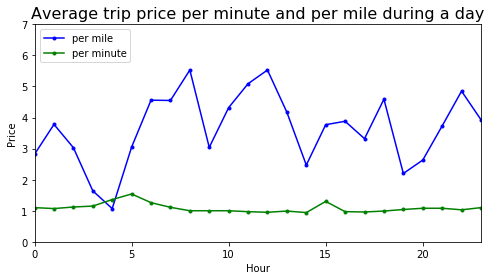

In [5]:
#Plot Average trip price per minute and per mile during a day

plt.figure(figsize=(8,4))

line_mile = plt.plot(df_trip['trip_hour'], df_trip['trip_price_per_mile'],'b.-', label = 'per mile')
line_minute = plt.plot(df_trip['trip_hour'], df_trip['trip_price_per_minute'],'g.-', label='per minute')

plt.xlabel('Hour')
plt.ylabel('Price')
plt.title('Average trip price per minute and per mile during a day', fontsize = 16)
plt.axis([0,23,0,7])
leg = plt.legend(loc = 'upper left')

plt.show()

It is pretty obvious that average trip price per minute is very stable at ~USD1, while average price per mile varies from ~USD1 to ~USD5.5.

*It means that total amount of the trip doesn't depend much on traveling time and traffic jams, it depends more on the trip distance.<br>
Higher average price per mile means that taxi drivers who pick up passengers for shorter rides at 8, 12, 18, 22 hours will get higher income.*

Now let's split statistic by weekday and **check if weekdays and weekends follow the same pattern.**<br>
We prepare another dataframe, which include weekday details, and plot average statistic during a day, depending on weekday.

In [6]:
%%bigquery df_trip_weekday
SELECT  FORMAT_DATE('%u', DATE(pickup_datetime)) as trip_weekday_no, 
        FORMAT_DATE('%A', DATE(pickup_datetime)) as trip_weekday,        
        Extract(hour from pickup_datetime) as trip_hour,
        COUNT(*) as trip_count,
        
        ROUND(AVG(TIMESTAMP_DIFF(dropoff_datetime, pickup_datetime, minute)),2) as trip_avg_time_m,
        ROUND(avg(trip_distance),2) as trip_avg_distance_mile,
        ROUND(AVG(total_amount),2) as trip_avg_total_amount        
FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
GROUP BY trip_weekday, trip_weekday_no,trip_hour
ORDER BY trip_weekday_no,trip_hour

In [7]:
#Prepare lists weekdays_no_list, weekdays_list and color_list for use in follolwing plot

weekday_no_list = df_trip_weekday.trip_weekday_no.drop_duplicates().values.tolist()
weekday_list = df_trip_weekday.trip_weekday.drop_duplicates().values.tolist()
color_list = ['#FF0000','#FF3333','#FF8000','#FFB266','#00CCCC','#00CC00','#0800FF']

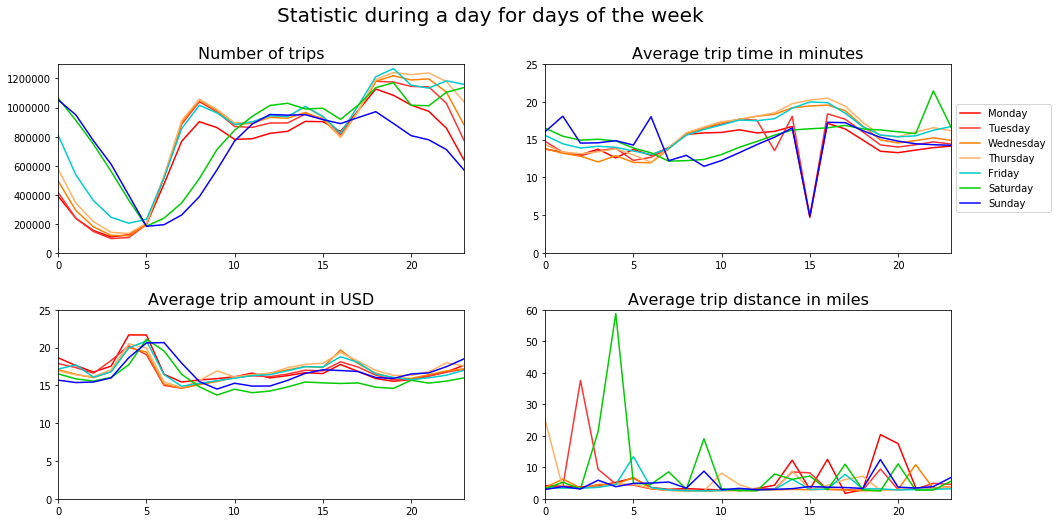

In [8]:
#Plot Average statistic during a day, depending on weekday: 
#Number of trips, Average trip time, Average trip cost, Average trip distance

plt.figure(figsize=(16,8))
plt.suptitle('Statistic during a day for days of the week', fontsize = 20)

plt.subplot(221)
for i in range(len(weekday_no_list)):
    df = df_trip_weekday.loc[df_trip_weekday['trip_weekday_no'] == weekday_no_list[i]]
    plt.plot(df['trip_hour'], df['trip_count'],color_list[i], label = weekday_list[i])
plt.title('Number of trips', fontsize = 16)
plt.axis([0,23,0,1300000])

plt.subplot(222)
for i in range(len(weekday_no_list)):
    df = df_trip_weekday.loc[df_trip_weekday['trip_weekday_no'] == weekday_no_list[i]]
    plt.plot(df['trip_hour'], df['trip_avg_time_m'],color_list[i], label = weekday_list[i])
plt.title('Average trip time in minutes', fontsize = 16)
plt.axis([0,23,0,25])
leg = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(223)
for i in range(len(weekday_no_list)):
    df = df_trip_weekday.loc[df_trip_weekday['trip_weekday_no'] == weekday_no_list[i]]
    plt.plot(df['trip_hour'], df['trip_avg_total_amount'],color_list[i], label = weekday_list[i])
plt.title('Average trip amount in USD', fontsize = 16)
plt.axis([0,23,0,25])

plt.subplot(224)
for i in range(len(weekday_no_list)):
    df = df_trip_weekday.loc[df_trip_weekday['trip_weekday_no'] == weekday_no_list[i]]
    plt.plot(df['trip_hour'], df['trip_avg_distance_mile'],color_list[i], label = weekday_list[i])
plt.title('Average trip distance in miles', fontsize = 16)
plt.axis([0,23,0,60])

plt.subplots_adjust(hspace=0.3)
plt.show()

Very obvious now, that weekends have separate pattern as well as Monday being different from the rest of the weekdays.

On weekends people do not use as much taxis from 5 hours to 10 hours in the morning, but use more taxis during nighttime from 0 to 5 hours compare to weekdays - probably they use yellow taxi to come back home after Friday night and Saturday night. Friday and Saturday 17 to 23 hours also have higher number of trips (because more people are going out at this time) with little dip around 20-21 hours when many people probably spend time over dinner or movie or elsewhere before heading to the next destination. Sunday evening has lowest number of trips, one of the possible reasons is that more people spend this time at home getting ready for a week.

Trip amount pattern is still the same, but weekends have peak at 5 hours compare to peak at 4 hours for weekdays.

Number of trips and average trip amount have dip and peak respectively at 16 hours over weekdays, which means there are lesser taxis available. This is true, because 16 to 17 hours is the time for cabs to change shifts.

Average trip time in minutes for Sundays and Mondays has big dip at 15 hours to 5 minutes. Other charts do not show any anomalies around 15 hours, have to investigate reasons in future (maybe church events? poor data?).
Average trip time on Saturdays at 22 h ours has peak (~22 minutes) as probably more people coming back home by taxi rather than by public transport. Generally during weekends people have shorter trips.

Average distance in miles has peak at 4 hours on Saturday (~60miles), possible reason is that people travel far to other counties for stay over weekend. And on Monday around 2 hours they are coming back. But far trips usually also long trips, and average trip time doesn't show long trips at these times.
On Monday evening 19 to 20 hours is another peak (~20 miles).

**Summary.<br>**
*There are obviously different patterns for weekends, Mondays and other weekdays. 
During weekdays when cabs change shift at 16-17 hours there are lesser yellow taxis available on the street, but demand is still there. People use more taxis on Saturday and Sunday night to come home after outing. (in future: check if pick up locations are more centralized and drop off locations are more remote for weekends nighttime)<br>
People have shorter trips over weekends during day time and longer trips on Saturday's evenings. (in future: investigate average time dip at 15 hours)<br>
From average distance split by weekday is not possible to draw any valuable insights - need to check data and find if there is relevance to some events.*

After we explore statistics during weekdays and during hours of day, let's look at the bigger picture.<br>
Our question is **"How does statistic changes throughout a year by month?"**

To answer this question we convert data to pivot tables and plot them as heatmaps.

In [9]:
%%bigquery df_trip_month
SELECT  FORMAT_DATE('%m', DATE(pickup_datetime)) as trip_month_no, 
        FORMAT_DATE('%B', DATE(pickup_datetime)) as trip_month,
        FORMAT_DATE('%u', DATE(pickup_datetime)) as trip_weekday_no, 
        FORMAT_DATE('%A', DATE(pickup_datetime)) as trip_weekday,        
        COUNT(*) as trip_count,
        
        ROUND(AVG(TIMESTAMP_DIFF(dropoff_datetime, pickup_datetime, minute)),2) as trip_avg_time_m,
        ROUND(avg(trip_distance),2) as trip_avg_distance_mile,
        ROUND(AVG(total_amount),2) as trip_avg_total_amount
FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
GROUP BY trip_weekday, trip_month, trip_month_no, trip_weekday_no
ORDER BY trip_month_no, trip_weekday_no

In [10]:
#Prepare weekday and month details for future use in plots

weekday_no_list = df_trip_month.trip_weekday_no.drop_duplicates().values.tolist()
weekday_list = df_trip_month.trip_weekday.drop_duplicates().values.tolist()
month_no_list = df_trip_month.trip_month_no.drop_duplicates().values.tolist()
month_list = df_trip_month.trip_month.drop_duplicates().values.tolist()

#Prepare pivot tables to be plotted as heatmaps

df_trip_month_count_pivot = df_trip_month.pivot(index = 'trip_weekday_no', columns = 'trip_month_no', values = 'trip_count')
df_trip_month_count_total = df_trip_month[['trip_month_no','trip_count']].groupby('trip_month_no').sum().T
df_trip_month_time_pivot = df_trip_month.pivot(index = 'trip_weekday_no', columns = 'trip_month_no', values = 'trip_avg_time_m')
df_trip_month_distance_pivot = df_trip_month.pivot(index = 'trip_weekday_no', columns = 'trip_month_no', values = 'trip_avg_distance_mile')
df_trip_month_amount_pivot = df_trip_month.pivot(index = 'trip_weekday_no', columns = 'trip_month_no', values = 'trip_avg_total_amount')


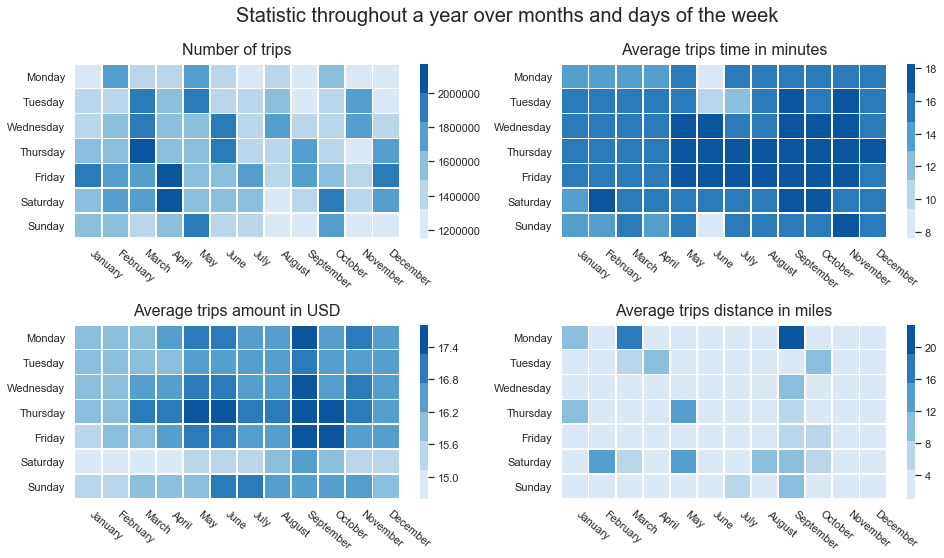

In [11]:
#Plot heatmaps for Statistic throughout a year over days of the week

sns.set()
cmap = sns.color_palette("Blues")

fig = plt.figure(figsize=(16,8))
rcParams['axes.titlepad'] = 10
plt.suptitle('Statistic throughout a year over months and days of the week', fontsize = 20)

plt.subplot(221)
ax1 = sns.heatmap(df_trip_month_count_pivot, cmap=cmap, linewidths=.5,cbar=True)
ax1.set_yticklabels(weekday_list, rotation=0)
ax1.set_xticklabels(month_list, rotation = -40, horizontalalignment='left')
plt.xlabel('')
plt.ylabel('')
ax1.set_title('Number of trips', fontsize = 16)

plt.subplot(222)
ax3 = sns.heatmap(df_trip_month_time_pivot, cmap=cmap, linewidths=.5,cbar=True)
ax3.set_yticklabels(weekday_list, rotation=0)
ax3.set_xticklabels(month_list, rotation = -40, horizontalalignment='left')
plt.xlabel('')
plt.ylabel('')
ax3.set_title('Average trips time in minutes', fontsize = 16)

plt.subplot(224)
ax4 = sns.heatmap(df_trip_month_distance_pivot, cmap=cmap, linewidths=.5,cbar=True)
ax4.set_yticklabels(weekday_list, rotation=0)
ax4.set_xticklabels(month_list, rotation = -40, horizontalalignment='left')
plt.xlabel('')
plt.ylabel('')
ax4.set_title('Average trips distance in miles', fontsize = 16)

plt.subplot(223)
ax5 = sns.heatmap(df_trip_month_amount_pivot, cmap=cmap, linewidths=.5,cbar=True)
ax5.set_yticklabels(weekday_list, rotation=0)
ax5.set_xticklabels(month_list, rotation = -40, horizontalalignment='left')
plt.xlabel('')
plt.ylabel('')
ax5.set_title('Average trips amount in USD', fontsize = 16)

plt.subplots_adjust(hspace=0.5)
plt.show()

*Generally there are more taxi trips during late winter (February) and spring (March, April). In March people took more taxis during weekdays, while in April there are more taxi trips during weekends and Fridays. There is obvious lesser demand during second half of the year. Probably it is relevant to New York's weather, have to investigate in future.*

*Even though second half of the year has lesser number of taxi trips, they tend to be longer in minutes and cost more.<br>
There are obvious outliers for average trip time in June (Mondays, Tuesdays and Sundays), have to investigate in future.<br>
On Saturdays for all months trips generally costs lesser, have to investigate in future.*

*On Mondays in March and September there are longer trips, as well as for the rest of the days in September, have to investigate in future.*

Looking at the data from months and weekdays, next questions rise:<br> 
**How does daily total statistic changes throughout a year?<br>
Are there particular patterns for total statistic over dates?**

We query data and prepare series plot for total statistic: total number of trips, total trips time in minutes, total trips distances in miles, total trips amount in USD.

In [12]:
%%bigquery df_trip_date
SELECT  DATE(pickup_datetime) as trip_date, 
        COUNT(*) as trip_count,
        
        ROUND(SUM(TIMESTAMP_DIFF(dropoff_datetime, pickup_datetime, minute)),2) as trip_sum_time_m,
        ROUND(SUM(trip_distance),2) as trip_sum_distance_mile,
        ROUND(SUM(total_amount),2) as trip_sum_total_amount
FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
GROUP BY trip_date
ORDER BY trip_date

C:\Users\Irinu\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


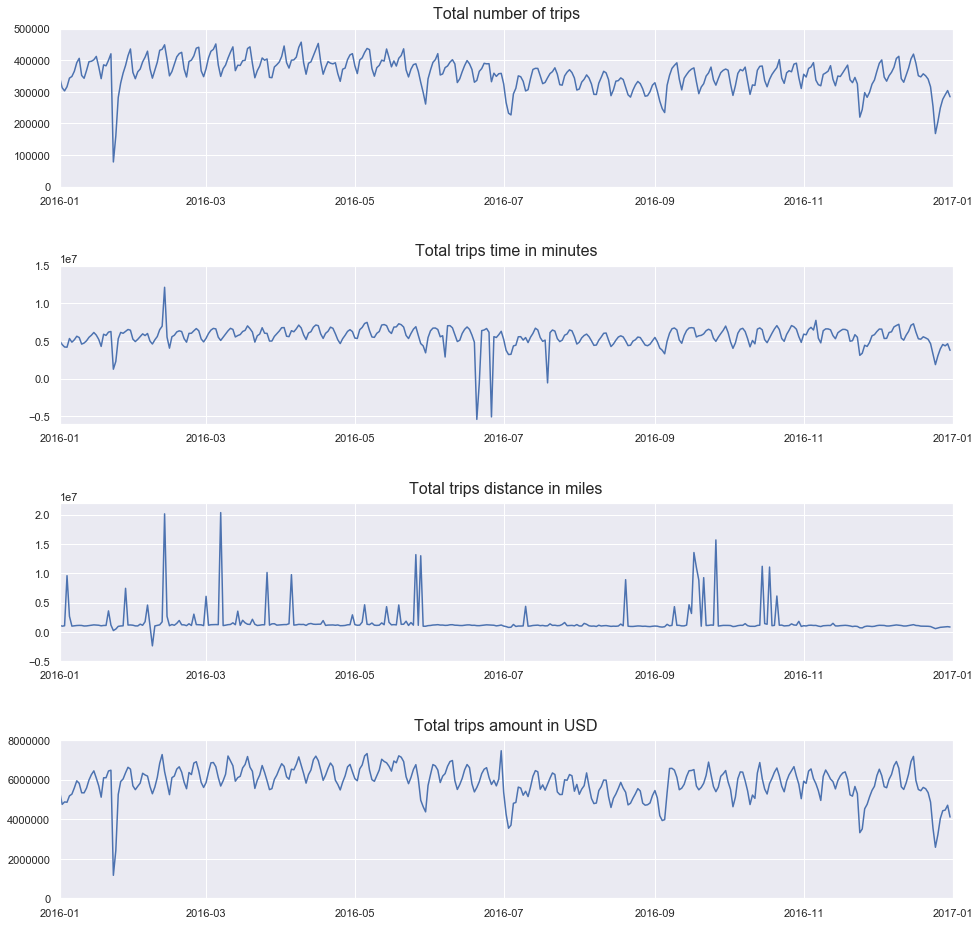

In [13]:
#Plot Total statistic for each day of 2016

plt.figure(figsize=(16,16))

plt.subplot(411)
sns.lineplot(x='trip_date', y='trip_count',data=df_trip_date)
plt.title('Total number of trips', fontsize = 16)
plt.grid(True)
plt.xlabel('')
plt.ylabel('')
plt.axis(['2016-01-01','2017-01-01',0, 500000])

plt.subplot(412)
sns.lineplot(x='trip_date', y='trip_sum_time_m',data=df_trip_date)
plt.title('Total trips time in minutes', fontsize = 16)
plt.grid(True)
plt.xlabel('')
plt.ylabel('')
plt.axis(['2016-01-01','2017-01-01',-6000000, 15000000])

plt.subplot(413)
ax = sns.lineplot(x='trip_date', y='trip_sum_distance_mile',data=df_trip_date)
plt.title('Total trips distance in miles', fontsize = 16)
plt.grid(True)
plt.xlabel('')
plt.ylabel('')
plt.axis(['2016-01-01','2017-01-01',-5000000, 22000000])

plt.subplot(414)
sns.lineplot(x='trip_date', y='trip_sum_total_amount',data=df_trip_date)
plt.title('Total trips amount in USD', fontsize = 16)
plt.grid(True)
plt.xlabel('')
plt.ylabel('')
plt.axis(['2016-01-01','2017-01-01',0,8000000])

plt.subplots_adjust(hspace=0.5)
plt.show()

There are obvious patterns in total statistic over dates, mostly related to weeks.<br>
**What are those bigger dips and higher peaks?**

To answer this question we add on details about public holidays (Fedreal Holidays) and other special days (observances, religious holidays, etc.)

I prepared Excel file 2016_Events.xlsx using data from https://www.nycbynatives.com/events/events_nyc.php, cleaning and adjusting in to be relevant to the task.

Using data from this file, I updated dataframe with new column 'special_day', indicating whether date is a public holiday('Public Holiday'), another special day ('Yes') or normal day ('No').

Now let's plot total statistic again.

In [14]:
#Upload details about public holidays and other special days in Ney York in 2016

df_events = pd.read_excel(r"2016_Events.xlsx")

In [15]:
#Update date format for df_trip_date and df_events

df_trip_date['trip_date'] = pd.to_datetime(df_trip_date['trip_date'], format='%Y/%m/%d')
df_events['Date'] = pd.to_datetime(df_events['Date'], format='%Y/%m/%d')


#Update df_trip_date with column 'special_day' to indicate if this day was 
#public holiday('Public Holiday'), another special day ('Yes') or normal day ('No')

def special_day(row):
    for i in range(len(df_events.Date)):
        if row['trip_date']==df_events.Date[i]:
            return 'Yes'
    return 'No'

df_trip_date['special_day'] = df_trip_date.apply(lambda row: special_day(row), axis = 1)

public_holidays = df_events.Date[df_events.Type == 'Federal Holiday']

def public_holiday(row):
    for i in range(len(public_holidays)):
        if row['trip_date'] == public_holidays.iloc[i]:
            return 'Public Holiday'
    return row['special_day']

df_trip_date['special_day'] = df_trip_date.apply(lambda row: public_holiday(row), axis = 1)

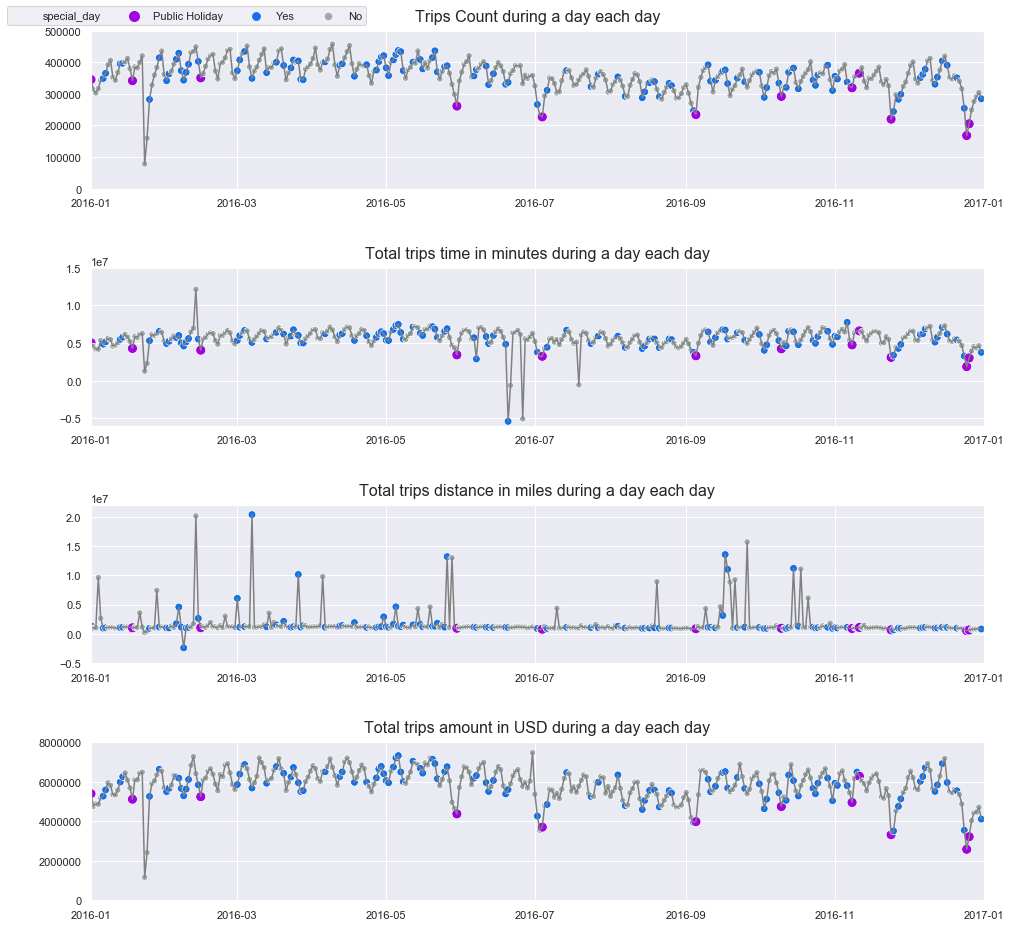

In [16]:
#Plot details about special dates over Total statistic for each day of 2016

plt.figure(figsize=(16,16))

flatui = ["#a102e2", "#1070ed", "#9daaaa"]
sns.set_palette(flatui)
order = ['Public Holiday','Yes','No']
sizes = {'Public Holiday':100,'Yes':60,'No':40}

plt.subplot(411)
ax = sns.scatterplot(x='trip_date', y='trip_count',hue = 'special_day', size = 'special_day', data=df_trip_date, 
                markers = 'o-',hue_order = order, sizes = sizes, legend = 'brief')
ax.legend(loc='lower left', bbox_to_anchor=(-0.1, 1), ncol=4)
plt.plot(df_trip_date['trip_date'],df_trip_date['trip_count'], color='grey')
plt.title('Trips Count during a day each day', fontsize = 16)
plt.grid(True)
plt.xlabel('')
plt.ylabel('')
plt.axis(['2016-01-01','2017-01-01',0, 500000])

plt.subplot(412)
plt.plot(df_trip_date['trip_date'],df_trip_date['trip_sum_time_m'], color='grey')
sns.scatterplot(x='trip_date', y='trip_sum_time_m',hue = 'special_day', size = 'special_day', data=df_trip_date, 
                markers = 'o-',hue_order = order, sizes = sizes, legend = False)
plt.title('Total trips time in minutes during a day each day', fontsize = 16)
plt.grid(True)
plt.xlabel('')
plt.ylabel('')
plt.axis(['2016-01-01','2017-01-01',-6000000, 15000000])

plt.subplot(413)
plt.plot(df_trip_date['trip_date'],df_trip_date['trip_sum_distance_mile'], color='grey')
sns.scatterplot(x='trip_date', y='trip_sum_distance_mile',hue = 'special_day', size = 'special_day', data=df_trip_date, 
                markers = 'o-',hue_order = order, sizes = sizes, legend = False)
plt.title('Total trips distance in miles during a day each day', fontsize = 16)
plt.grid(True)
plt.xlabel('')
plt.ylabel('')
plt.axis(['2016-01-01','2017-01-01',-5000000, 22000000])

plt.subplot(414)
plt.plot(df_trip_date['trip_date'],df_trip_date['trip_sum_total_amount'], color='grey')
sns.scatterplot(x='trip_date', y='trip_sum_total_amount',hue = 'special_day', size = 'special_day', data=df_trip_date, 
                markers = 'o-',hue_order = order, sizes = sizes, legend = False)
plt.title('Total trips amount in USD during a day each day', fontsize = 16)
plt.grid(True)
plt.xlabel('')
plt.ylabel('')
plt.axis(['2016-01-01','2017-01-01',0,8000000])

plt.subplots_adjust(hspace=0.5)
plt.show()

It is very clear now that public holidays affect New York taxis and there are lesser trips on public holidays compare to other days during that month. Most of other special days do not cause any interruption to taxi business.

Apart from special days, there are few outlying points. We will check exact dates for
- biggest dip of total number of trips
- 4 biggest dips and 1 peak of total trips time
- peaks for total trips distances (are they weekends?)
- biggest dip and 2 highest peaks for total trips amount

Biggest dip of total number of trips happen on 23 January 2016.<br>
Quick google search explains it:<br>
"The January 2016 United States blizzard was a crippling and historic blizzard that produced up to 3 ft (91 cm) of snow in parts of the Mid-Atlantic and Northeast United States from January 22 to January 24, 2016." (https://en.wikipedia.org/wiki/January_2016_United_States_blizzard)

In [17]:
df_trip_date.sort_values(['trip_count'], ascending=True).iloc[0]

trip_date                 2016-01-23 00:00:00
trip_count                              78133
trip_sum_time_m                   1.26137e+06
trip_sum_distance_mile                 216758
trip_sum_total_amount              1.1628e+06
special_day                                No
Name: 22, dtype: object

Peak of total trips time happen on 13 February 2016.<br>
Quick google search doesn't show major events for this date.

In [18]:
df_trip_date.sort_values(['trip_sum_time_m'], ascending=False).iloc[0]

trip_date                 2016-02-13 00:00:00
trip_count                             448611
trip_sum_time_m                   1.21402e+07
trip_sum_distance_mile            2.01394e+07
trip_sum_total_amount             6.40839e+06
special_day                                No
Name: 43, dtype: object

Dips of total trips time have values below 0, which means we should check data for these dates.<br>
Date of 23 January (lowest from positive values) already explained by blizzard.

In [19]:
df_trip_date.sort_values(['trip_sum_time_m'], ascending=True).iloc[0:6]

,trip_date,trip_count,trip_sum_time_m,trip_sum_distance_mile,trip_sum_total_amount,special_day
171,2016-06-20,335992,-5401338.0,1053546.40,5606556.43,Yes
177,2016-06-26,331802,-5069835.0,1149684.87,5759014.17,No
172,2016-06-21,364462,-629434.0,1048123.51,5895466.63,No
200,2016-07-19,344310,-555372.0,1028319.57,5775573.63,No
22,2016-01-23,78133,1261368.0,216758.16,1162798.76,No
359,2016-12-25,167893,1869809.0,543298.91,2581452.18,Public Holiday


Majority of peaks in total trips distances happen on special day (Hindu and Christian Holidays and Observances) - most probably people are travelling to the religious places of worship.

26 September 2016: The First 2016 Presidential Debate was held at Hofstra University, located in Hempstead, NY, which is ~32 miles away from Manhattan.

28 May 2016: 2016 New York Red Bulls season game, held in Harrison, New Jersey, which is ~14 miles away from Manhattan.

As summary, people use taxis to travel to big events and to the religious places of worship, which are located farther away from Manhattan.

In [20]:
df_trip_date.sort_values(['trip_sum_distance_mile'], ascending=False).iloc[0:10]

,trip_date,trip_count,trip_sum_time_m,trip_sum_distance_mile,trip_sum_total_amount,special_day
66,2016-03-07,348700,5078985.0,20354412.50,5679277.88,Yes
43,2016-02-13,448611,12140157.0,20139371.12,6408386.21,No
269,2016-09-26,320999,4961526.0,15687039.10,5394791.07,No
260,2016-09-17,375619,6730953.0,13534974.63,6511302.70,Yes
146,2016-05-26,388607,6906511.0,13177418.43,6760157.24,Yes
148,2016-05-28,329787,4666175.0,12985814.23,4962603.27,No
288,2016-10-15,381537,6491954.0,11183678.54,6053812.20,Yes
291,2016-10-18,339332,5423919.0,11055229.61,5802727.79,No
261,2016-09-18,332291,5541891.0,11010171.27,5682823.10,Yes
85,2016-03-26,403899,6018407.0,10128840.61,5947962.92,Yes


Biggest dip in total trips distance happen on Chinese New Year 8 February 2016 and has negative value. Have to check data for this date.<br>
The next dip is on 23 January 2016, when blizzard happen.

In [21]:
df_trip_date.sort_values(['trip_sum_distance_mile'], ascending=True).iloc[0:2]

,trip_date,trip_count,trip_sum_time_m,trip_sum_distance_mile,trip_sum_total_amount,special_day
38,2016-02-08,343066,4606841.0,-2399265.03,5288225.22,Yes
22,2016-01-23,78133,1261368.0,216758.16,1162798.76,No


Lowest total trips amount is on 23 January and 24 January 2016, when blizzard happen.

In [22]:
df_trip_date.sort_values(['trip_sum_total_amount'], ascending=True).iloc[0:2]

,trip_date,trip_count,trip_sum_time_m,trip_sum_distance_mile,trip_sum_total_amount,special_day
22,2016-01-23,78133,1261368.0,216758.16,1162798.76,No
23,2016-01-24,159766,2291591.0,469222.21,2412178.94,No


*As a summary, it is very obvious, that public holidays affect taxi business, but we also have seen, that bad weather and major events affect it too.*